# Forecasting with different solutions

We wil review the following options:

* SARIMA Model using Auto Arima
* Recurrent Neural Nets
* Convolutional Neural Nets
* Facebook's Prophet Library

The goal is to compare and find which one serves the best forecast and write a short article on each.

## Data Prep and Exploration 
*Note different model approaches might require a different data prep

In [1]:
install_dependencies = False
if install_dependencies:
    !pip install plotly==4.12.0
    !pip install pmdarima
    !pip install pystan
    !pip install fbprophet

In [2]:
#Import Data and Viz Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

#Stats Library
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Evaluation metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#Facebook Prophet Libraries
from fbprophet import Prophet

#Tensorflow library
import tensorflow as tf

In [3]:
#Clean the currency column to make it a float
#The Revenue column is a string so we need to convert to floatdef clean_currency(x):
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('£', '').replace(',', ''))
    return(x)

In [5]:
df = pd.read_csv("data/fashion_retail_20200701_20201031.csv")
df.head()

Date      Revenue
0  20200701  £310,125.53
1  20200702  £267,367.19
2  20200703  £259,462.99
3  20200704  £225,009.43
4  20200705  £256,431.46

In [6]:
#Convert Date column to timestamp
df.set_index('Date',inplace=True)
df.head()

Revenue
Date                 
20200701  £310,125.53
20200702  £267,367.19
20200703  £259,462.99
20200704  £225,009.43
20200705  £256,431.46

In [7]:
df.index = pd.to_datetime(df.index,format="%Y%m%d")
df.head()

Revenue
Date                   
2020-07-01  £310,125.53
2020-07-02  £267,367.19
2020-07-03  £259,462.99
2020-07-04  £225,009.43
2020-07-05  £256,431.46

In [8]:
#Convert Revenue column to Float
df["Revenue"] = df['Revenue'].apply(clean_currency).astype('float')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2020-07-01 to 2020-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


## Data Visualization

### Line plot

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




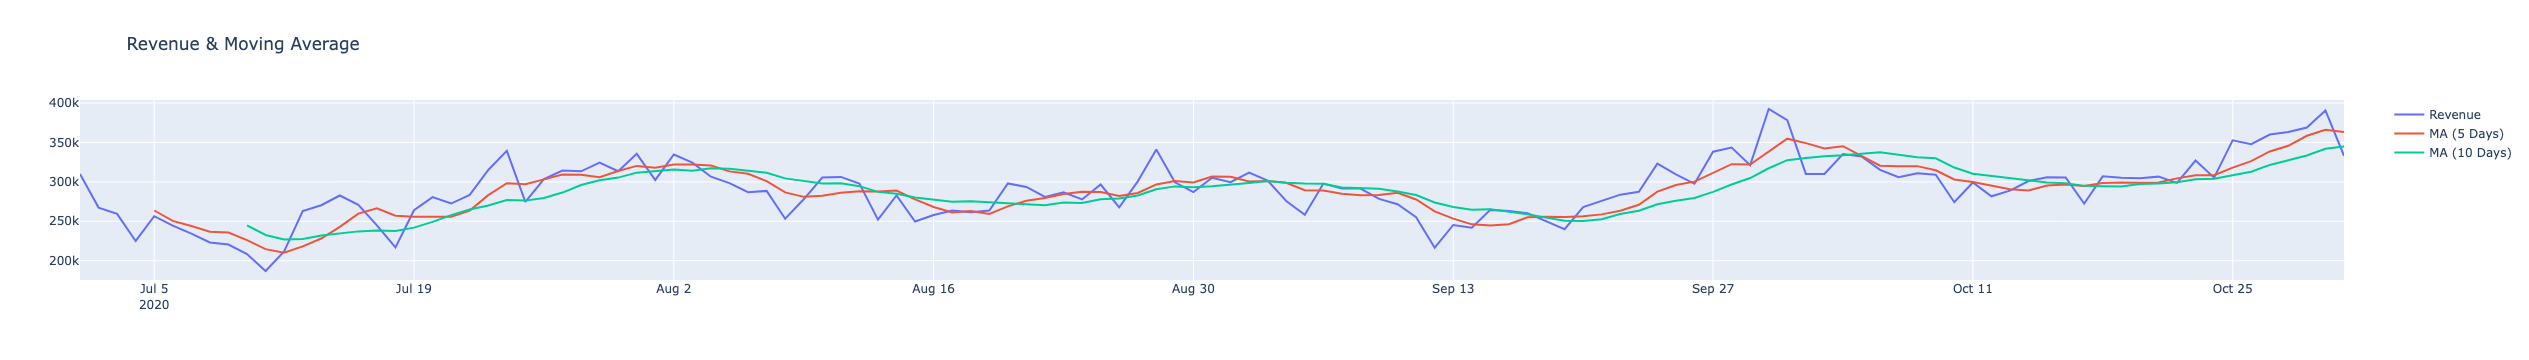

In [11]:
#fig = px.line(df,x=df.index,y=["Revenue",df.Revenue.rolling(10).mean()],title="Time Series Revenue Range")
fig = go.Figure()
fig.add_trace(go.Line(x=df.index,y=df["Revenue"],name="Revenue"))
fig.add_trace(go.Line(x=df.index,y=df.Revenue.rolling(5).mean(),name="MA (5 Days)"))
fig.add_trace(go.Line(x=df.index,y=df.Revenue.rolling(10).mean(),name="MA (10 Days)"))
fig.update_layout(title="Revenue & Moving Average")
fig.show()
#fig2 = px.line(df.Revenue.rolling(10).mean(),x=df.index,y="Revenue")

#fig2.show()

In [12]:
#Adding the day of the week to see if there are specific days when the revenue increase
df["week_day"] = list(pd.Series(df.index).dt.day_name())
df.head()

Revenue   week_day
Date                            
2020-07-01  310125.53  Wednesday
2020-07-02  267367.19   Thursday
2020-07-03  259462.99     Friday
2020-07-04  225009.43   Saturday
2020-07-05  256431.46     Sunday

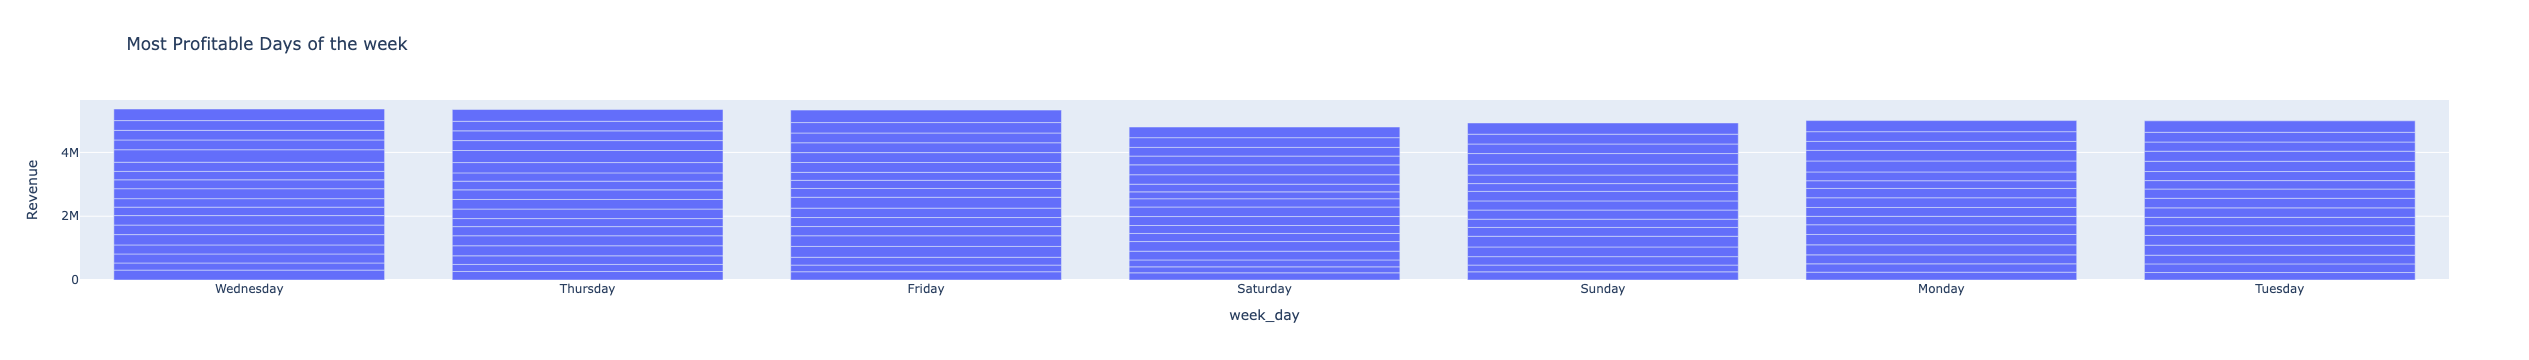

In [13]:
fig = px.bar(df,x="week_day",y="Revenue",title="Most Profitable Days of the week")
fig.show()

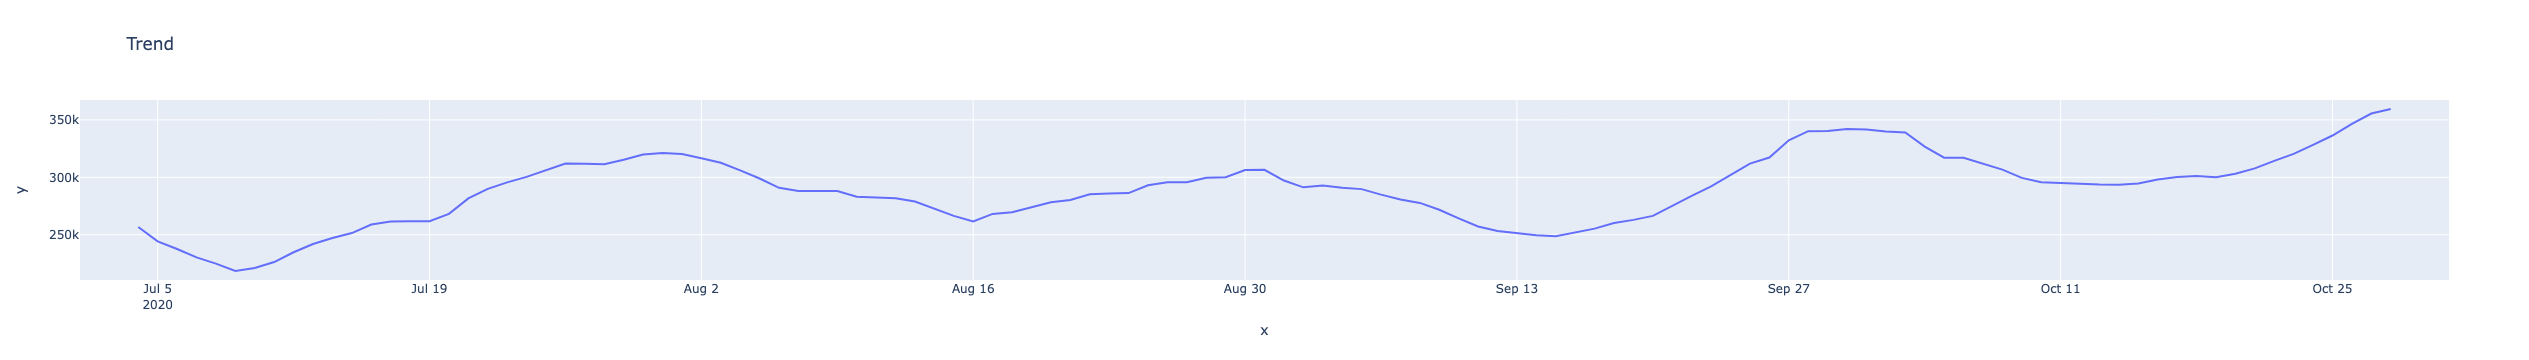

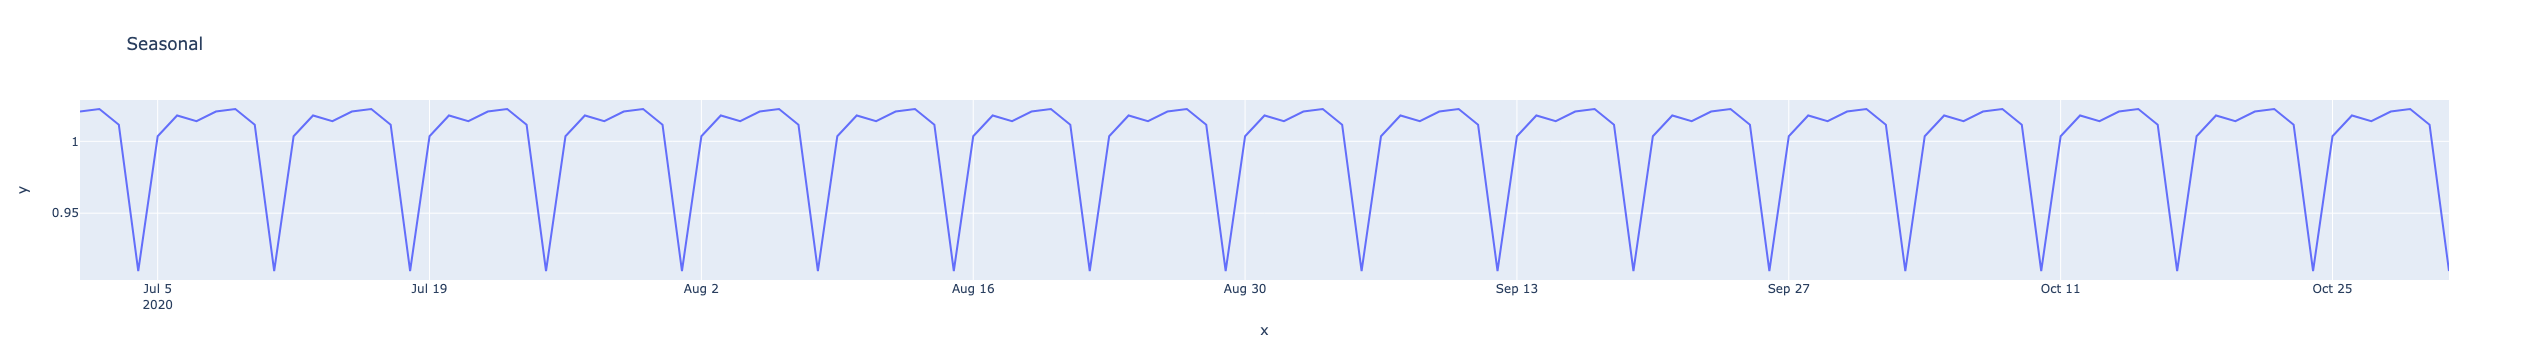

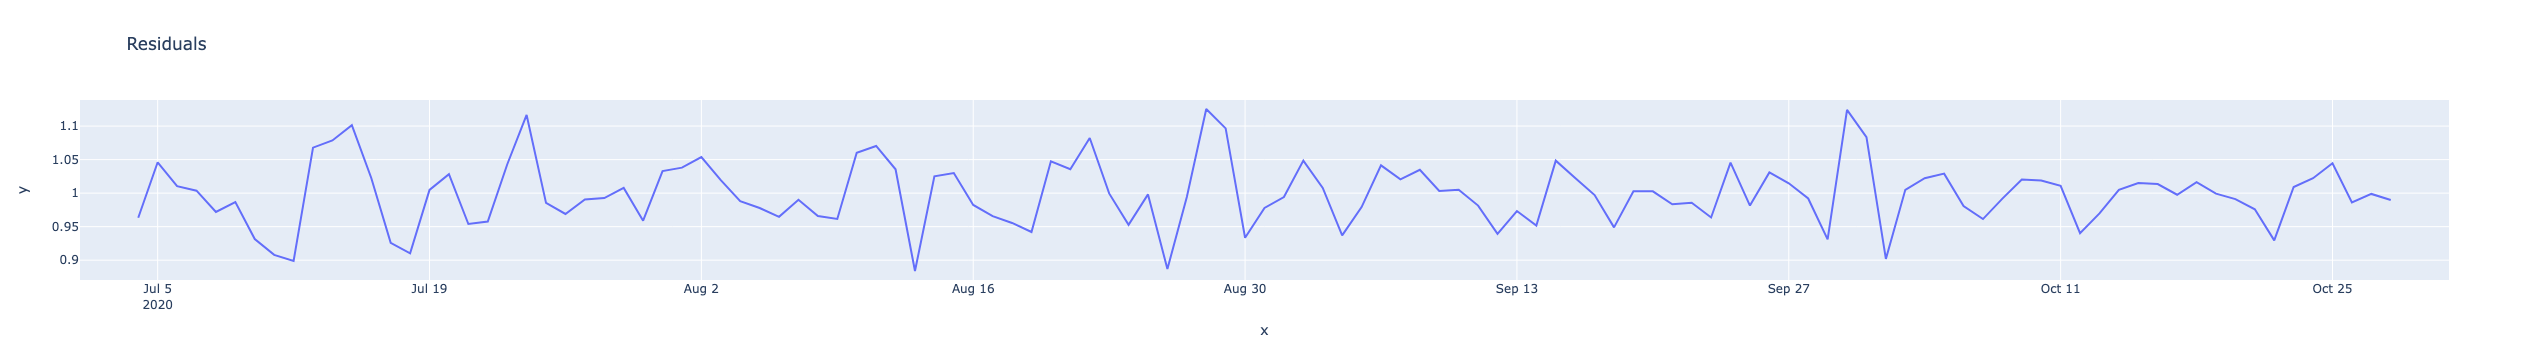

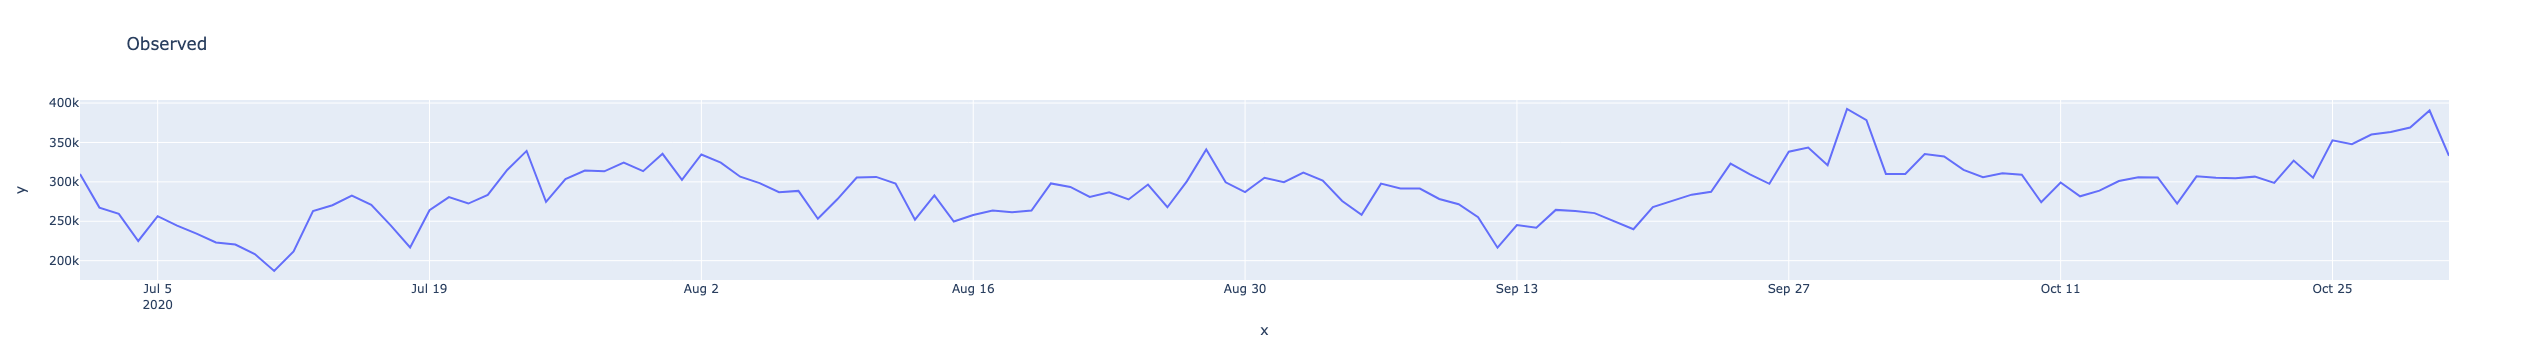

In [14]:
results = seasonal_decompose(df["Revenue"],model="mutliplicative")
fig1 = px.line(results.trend,x=df.index,y=results.trend, title="Trend")
fig2 = px.line(results.seasonal,x=df.index,y=results.seasonal, title="Seasonal")
fig3 = px.line(results.resid,x=df.index,y=results.resid, title="Residuals")
fig4 = px.line(results.observed,x=df.index,y=results.observed, title="Observed")
fig1.show()
fig2.show()
fig3.show()
fig4.show()

## SARIMA Model

This is a time series forecasting technique called *Seasonal Autoregressive Integrated Moving Average Exogenous*, it is similar to *Autogressive Inegrated Moving Average Exogenous* but it included another set of parameters for P,D, Q which are for seasonality. 

We can some from the *Seasonal* plot above that there is some seasonality. This means we might need to account for seasonality. Even in the *Observed* plot we see some seasonality but not a great deal. This means we will need to add some differencing to help idenitify seasonality. 

I am going to use the auto_arima library to determine the right values for PDQ.

In [24]:
auto_arima(df["Revenue"],seasonal=True,m=14).summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  123
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 14)   Log Likelihood               -1391.717
Date:                             Sat, 12 Dec 2020   AIC                           2793.434
Time:                                     12:53:37   BIC                           2807.454
Sample:                                          0   HQIC                          2799.128
                                             - 123                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3910      0.208      1.884      0.060      -0.016       0.798
ma.L1         -0.6186      0.174     -3.563      0.000      -0.959      -0.278
ar.S.L14       0.1032      0.076      1.357      0.175      -0.046       0.252
ar.S.L28       0.1492      0.050      3.007      0.003       0.052       0.247
sigma2      5.195e+08   1.21e-10   4.29e+18      0.000     5.2e+08     5.2e+08
===================================================================================
Ljung-Box (Q):                       58.12   Jarque-Bera (JB):                 0.67
Prob(Q):                              0.03   Prob(JB):                         0.72
Heteroskedasticity (H):               1.03   Skew:                             0.13
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.44e+34. Standard errors may be unstable.
"""

In [25]:
#Split the dataset
sarima_train = df.iloc[:90]
sarima_test = df.iloc[90:]

In [26]:
sarima_model = SARIMAX(sarima_train["Revenue"],order=(1,1,1),seasonal_order=(0,0,1,14))
sarima_results = sarima_model.fit()
sarima_results.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(0, 0, 1, 14)   Log Likelihood               -1014.242
Date:                            Sat, 12 Dec 2020   AIC                           2036.485
Time:                                    12:53:52   BIC                           2046.439
Sample:                                07-01-2020   HQIC                          2040.497
                                     - 09-28-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5011      0.267      1.874      0.061      -0.023       1.025
ma.L1         -0.6803      0.220     -3.090      0.002      -1.112      -0.249
ma.S.L14       0.1002      0.092      1.088      0.277      -0.080       0.281
sigma2      4.825e+08   1.64e-10   2.93e+18      0.000    4.83e+08    4.83e+08
===================================================================================
Ljung-Box (Q):                       78.60   Jarque-Bera (JB):                 0.43
Prob(Q):                              0.00   Prob(JB):                         0.81
Heteroskedasticity (H):               0.63   Skew:                             0.04
Prob(H) (two-sided):                  0.21   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.95e+34. Standard errors may be unstable.
"""

In [27]:
#Getting start and end dates fro model
start = len(sarima_train)
end = start + len(sarima_test) - 1

In [30]:
sarima_predictions = sarima_results.predict(start=start,end=end,typ="levels").rename("SARIMAX(1, 1, 1)x(0, 0, 1, 14)")

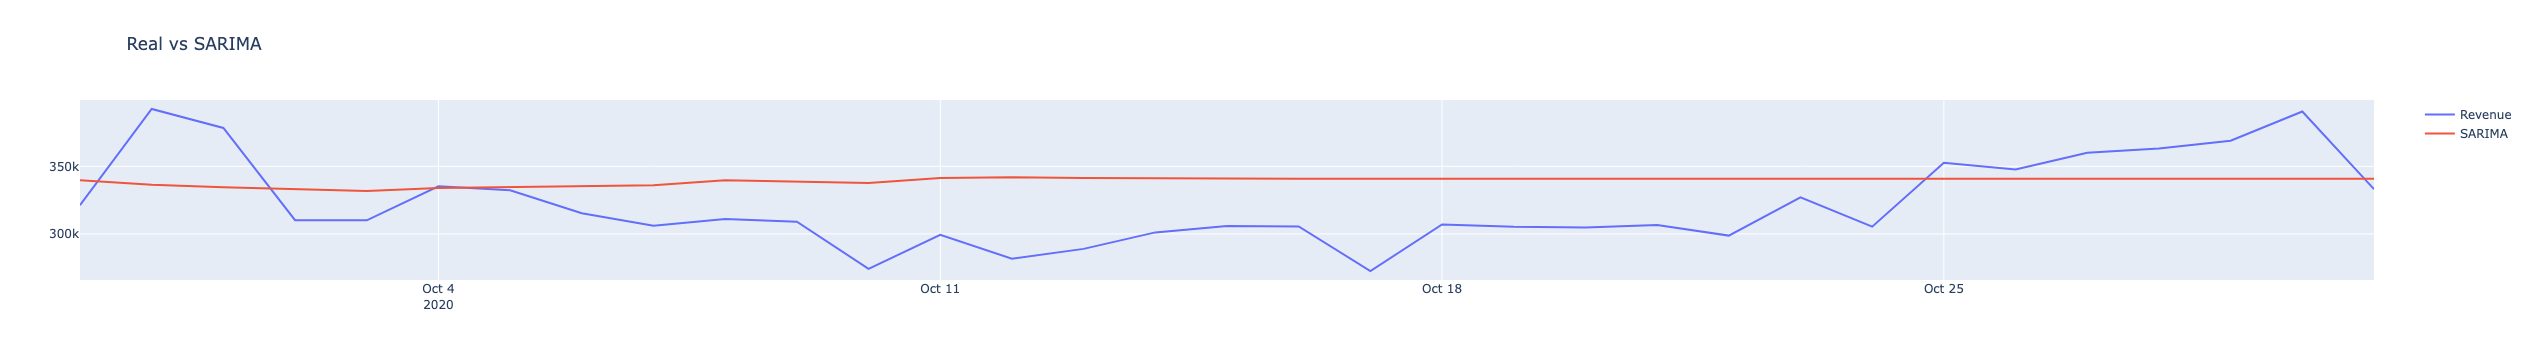

In [31]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=sarima_predictions.index,y=sarima_predictions,name="SARIMA"))
fig.update_layout(title="Real vs SARIMA")
fig.show()

## Facebook's Prophet Library

This is a open source library from Facebook which is a procedure for time series forecasting on additive model where there are non-linear trends.

It is meant to be fast, accurate, automated and tunable to your data.

Facebook's prophets requires specifics values for the columns and only two columns Datetime & Target Variable.

In [32]:
#Removing the weekend day column
df_fb = df.copy()
df_fb.drop(columns="week_day",axis=1,inplace=True)
df_fb.head()

Revenue
Date                 
2020-07-01  310125.53
2020-07-02  267367.19
2020-07-03  259462.99
2020-07-04  225009.43
2020-07-05  256431.46

In [33]:
#Converting date index back into date
df_fb["ds"] = df.index
df_fb.head()

Revenue         ds
Date                            
2020-07-01  310125.53 2020-07-01
2020-07-02  267367.19 2020-07-02
2020-07-03  259462.99 2020-07-03
2020-07-04  225009.43 2020-07-04
2020-07-05  256431.46 2020-07-05

In [34]:
df_fb.columns=["y","ds"]
df_fb.head()

y         ds
Date                            
2020-07-01  310125.53 2020-07-01
2020-07-02  267367.19 2020-07-02
2020-07-03  259462.99 2020-07-03
2020-07-04  225009.43 2020-07-04
2020-07-05  256431.46 2020-07-05

In [35]:
df_fb.reset_index(inplace=True)

In [36]:
df_fb.drop(columns="Date",axis=1,inplace=True)
df_fb.head()

y         ds
0  310125.53 2020-07-01
1  267367.19 2020-07-02
2  259462.99 2020-07-03
3  225009.43 2020-07-04
4  256431.46 2020-07-05

In [37]:
#Date column or ds needs to be a datetime object
df_fb["ds"] = pd.to_datetime(df_fb["ds"])
df_fb.head()

y         ds
0  310125.53 2020-07-01
1  267367.19 2020-07-02
2  259462.99 2020-07-03
3  225009.43 2020-07-04
4  256431.46 2020-07-05

In [38]:
#Forecasting with no train test split
fb_model = Prophet()
fb_model.fit(df_fb)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [39]:
#Forecast into the future
future = fb_model.make_future_dataframe(periods=30) #predicting 30 days into the future

In [40]:
future

ds
0   2020-07-01
1   2020-07-02
2   2020-07-03
3   2020-07-04
4   2020-07-05
..         ...
148 2020-11-26
149 2020-11-27
150 2020-11-28
151 2020-11-29
152 2020-11-30

[153 rows x 1 columns]

In [41]:
forecast = fb_model.predict(future)

In [42]:
forecast

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   2020-07-01  259884.163223  229574.962935  305429.552621  259884.163223   
1   2020-07-02  260353.553978  227683.952985  305023.843449  260353.553978   
2   2020-07-03  260822.944733  227868.018067  305524.229747  260822.944733   
3   2020-07-04  261292.335488  196950.122502  274209.152376  261292.335488   
4   2020-07-05  261761.726243  222623.667113  298915.923025  261761.726243   
..         ...            ...            ...            ...            ...   
148 2020-11-26  347139.416097  315022.489686  390873.177071  346565.776568   
149 2020-11-27  347856.758232  313275.696729  392641.392373  347254.526220   
150 2020-11-28  348574.100366  285149.432093  360078.957071  347944.687197   
151 2020-11-29  349291.442501  310768.209130  384684.395863  348616.255392   
152 2020-11-30  350008.784635  313787.157107  389723.636055  349297.983097   

       trend_upper  additive_terms  additive_terms_lower  \
0    259884.163223     7968.043607           7968.043607   
1    260353.553978     6485.030289           6485.030289   
2    260822.944733     4900.221182           4900.221182   
3    261292.335488   -25054.802543         -25054.802543   
4    261761.726243     -312.693985           -312.693985   
..             ...             ...                   ...   
148  347749.097092     6485.030289           6485.030289   
149  348506.168313     4900.221182           4900.221182   
150  349264.756836   -25054.802543         -25054.802543   
151  350028.749387     -312.693985           -312.693985   
152  350779.770862     3517.613159           3517.613159   

     additive_terms_upper        weekly  weekly_lower  weekly_upper  \
0             7968.043607   7968.043607   7968.043607   7968.043607   
1             6485.030289   6485.030289   6485.030289   6485.030289   
2             4900.221182   4900.221182   4900.221182   4900.221182   
3           -25054.802543 -25054.802543 -25054.802543 -25054.802543   
4             -312.693985   -312.693985   -312.693985   -312.693985   
..                    ...           ...           ...           ...   
148           6485.030289   6485.030289   6485.030289   6485.030289   
149           4900.221182   4900.221182   4900.221182   4900.221182   
150         -25054.802543 -25054.802543 -25054.802543 -25054.802543   
151           -312.693985   -312.693985   -312.693985   -312.693985   
152           3517.613159   3517.613159   3517.613159   3517.613159   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
148                   0.0                         0.0   
149                   0.0                         0.0   
150                   0.0                         0.0   
151                   0.0                         0.0   
152                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
0                           0.0  267852.206831  
1                           0.0  266838.584267  
2                           0.0  265723.165916  
3                           0.0  236237.532946  
4                           0.0  261449.032258  
..                          ...            ...  
148                         0.0  353624.446387  
149                         0.0  352756.979414  
150                         0.0  323519.297824  
151                         0.0  348978.748516  
152                         0.0  353526.397794  

[153 rows x 16 columns]

In [43]:
forecast[['ds','yhat_lower','yhat_upper','yhat']]

ds     yhat_lower     yhat_upper           yhat
0   2020-07-01  229574.962935  305429.552621  267852.206831
1   2020-07-02  227683.952985  305023.843449  266838.584267
2   2020-07-03  227868.018067  305524.229747  265723.165916
3   2020-07-04  196950.122502  274209.152376  236237.532946
4   2020-07-05  222623.667113  298915.923025  261449.032258
..         ...            ...            ...            ...
148 2020-11-26  315022.489686  390873.177071  353624.446387
149 2020-11-27  313275.696729  392641.392373  352756.979414
150 2020-11-28  285149.432093  360078.957071  323519.297824
151 2020-11-29  310768.209130  384684.395863  348978.748516
152 2020-11-30  313787.157107  389723.636055  353526.397794

[153 rows x 4 columns]

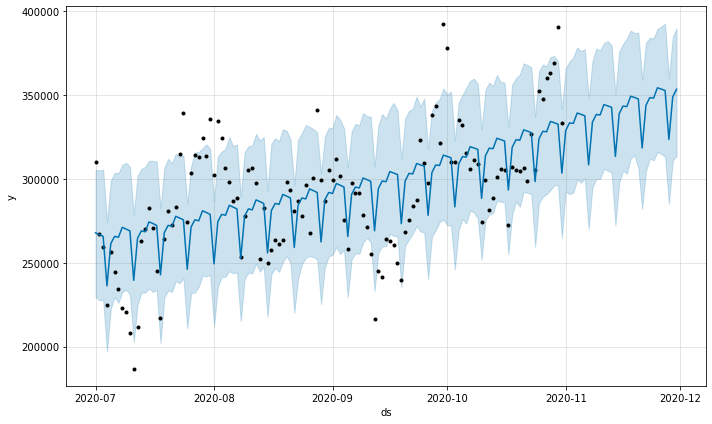

In [44]:
fb_model.plot(forecast); #At thist stage we are predicting until the end of the year but we want to  test

In [45]:
#Create prophets train and test  datasets
fb_train = df_fb.iloc[:90]
fb_test = df_fb.iloc[90:]

In [46]:
fb_prophet_model = Prophet(seasonality_mode="multiplicative",weekly_seasonality=True)
fb_prophet_model.fit(fb_train)
prophet_future = fb_prophet_model.make_future_dataframe(periods=33,freq="D")
prophet_forecast = fb_prophet_model.predict(prophet_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


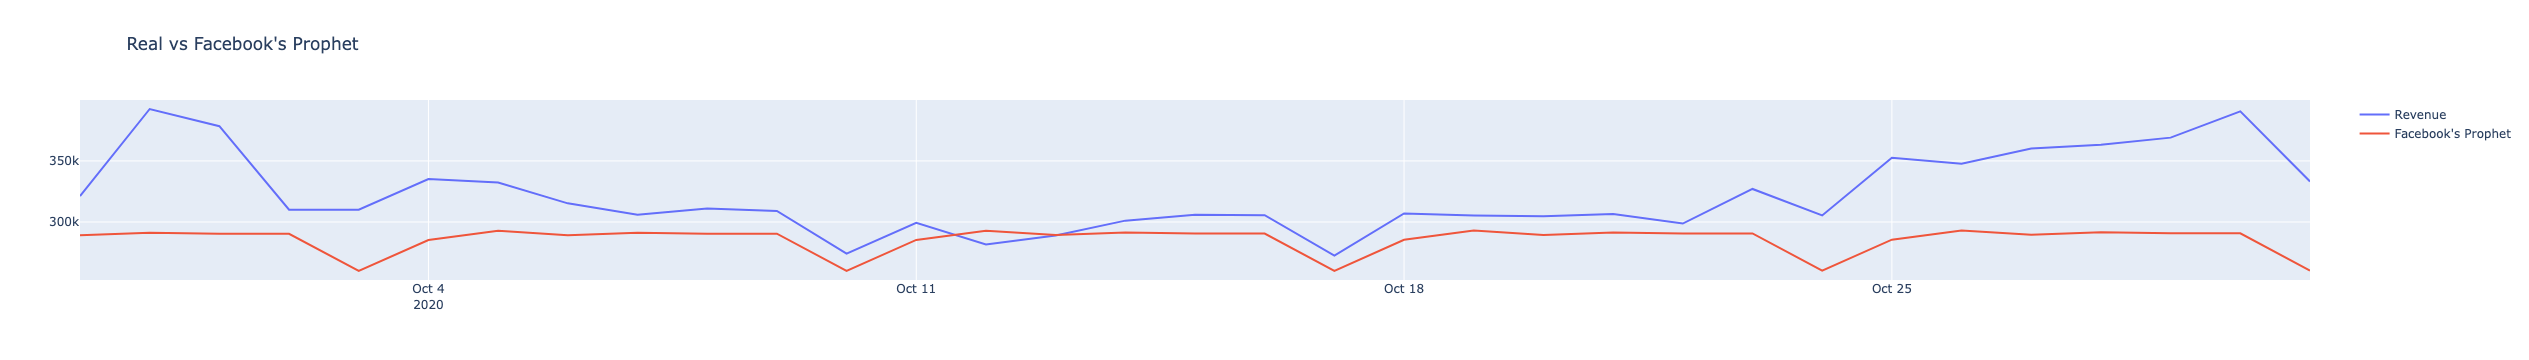

In [48]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=prophet_forecast["ds"].iloc[90:],y=prophet_forecast["yhat"].iloc[90:],name="Facebook's Prophet"))
fig.update_layout(title="Real vs Facebook's Prophet")
fig.show()

In [49]:
#Prophets includes their own evaluation diagnonstics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [50]:
#INTIAL
initial = str(30) + ' days'
#PERIOD
period = str(10) + ' days'
#HORIZON
horizon = str(5) + ' days'

In [51]:
fb_cv = cross_validation(fb_prophet_model,initial= initial, period=period,horizon=horizon)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-08-04 00:00:00 and 2020-09-23 00:00:00


In [52]:
fb_cv.head()

ds           yhat     yhat_lower     yhat_upper          y  \
0 2020-08-05  348092.504694  317233.256268  380125.340439  298387.24   
1 2020-08-06  340417.709740  309224.970880  372811.553193  286876.16   
2 2020-08-07  341631.105777  310457.204810  372844.107941  288568.58   
3 2020-08-08  296243.017178  266396.536614  329174.974692  253175.06   
4 2020-08-09  335639.778339  304349.886774  368388.612153  277877.36   

      cutoff  
0 2020-08-04  
1 2020-08-04  
2 2020-08-04  
3 2020-08-04  
4 2020-08-04

In [53]:
performance_metrics(fb_cv)

horizon           mse          rmse           mae      mape     mdape  \
0  1 days  1.540347e+09  39247.248522  36420.828952  0.130521  0.140205   
1  2 days  1.420269e+09  37686.456060  34472.561554  0.125240  0.108078   
2  3 days  1.812044e+09  42568.111292  36059.887890  0.128489  0.139582   
3  4 days  2.418562e+09  49178.882545  44598.386510  0.152139  0.162043   
4  5 days  2.787603e+09  52797.755594  48571.010222  0.168927  0.180007   

   coverage  
0  0.333333  
1  0.500000  
2  0.500000  
3  0.333333  
4  0.166667

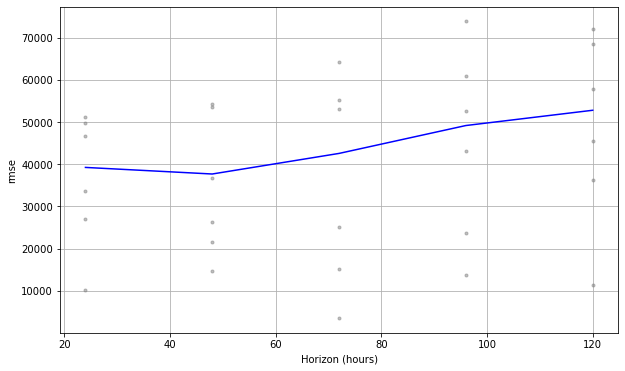

In [54]:
plot_cross_validation_metric(fb_cv,metric='rmse');

## Tensorflow Recurrent Neural Nets

Recurrents Neural Nets are useful for time series analysis because it can look back at the previous step and the current step before it makes it predictions. 

In [55]:
df_tf = df.copy()
df_tf.head()

Revenue   week_day
Date                            
2020-07-01  310125.53  Wednesday
2020-07-02  267367.19   Thursday
2020-07-03  259462.99     Friday
2020-07-04  225009.43   Saturday
2020-07-05  256431.46     Sunday

In [56]:
#Create train and test split
tf_train = df_tf[['Revenue']].iloc[:90]
tf_test = df_tf[['Revenue']].iloc[90:]

In [57]:
#Scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [58]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

standard_train = standard_scaler.fit_transform(tf_train)
minmax_train = minmax_scaler.fit_transform(tf_train)

standard_test = standard_scaler.fit_transform(tf_test)
minmax_test = minmax_scaler.fit_transform(tf_test)

### Using a TimeseriesGenerator

In [59]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [60]:
n_inputs = 12
n_features = 1

timeseries_gen = TimeseriesGenerator(standard_train,standard_train,length=n_inputs,batch_size=1)

In [61]:
X, y = timeseries_gen[0]
X.shape

(1, 12, 1)

In [62]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.01):
            print("\nReached acceptable loss!")
            self.model.stop_training = True

In [63]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

In [64]:
tf_model = Sequential()
tf_model.add(LSTM(600,activation='relu',input_shape=(n_inputs,n_features)))
tf_model.add(Dense(1))
tf_model.compile(optimizer='adam',loss='mse')

In [65]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600)               1444800   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [66]:
callback = myCallback()
tf_model.fit_generator(timeseries_gen,epochs=100,callbacks=[callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/100
78/78 [==============================] - 5s 63ms/step - loss: 0.7314
Epoch 2/100
78/78 [==============================] - 5s 59ms/step - loss: 0.5347
Epoch 3/100
78/78 [==============================] - 4s 56ms/step - loss: 0.5532
Epoch 4/100
78/78 [==============================] - 5s 62ms/step - loss: 0.5024
Epoch 5/100
78/78 [==============================] - 4s 51ms/step - loss: 0.4705
Epoch 6/100
78/78 [==============================] - 4s 49ms/step - loss: 0.4575
Epoch 7/100
78/78 [==============================] - 4s 48ms/step - loss: 0.4457
Epoch 8/100
78/78 [==============================] - 4s 53ms/step - loss: 0.4347
Epoch 9/100
78/78 [==============================] - 4s 54ms/step - loss: 0.4137
Epoch 10/100
78/78 [==============================] - 3s 44ms/step - loss: 0.4403
Epoch 11/100
78/78 [==============================] - 4s 53ms/step - loss: 0.4071
Epoch 12/100
78/78 [==============================] - 4s 50ms/step - loss: 0.4046
Epoch 13/100
78/78 [=====

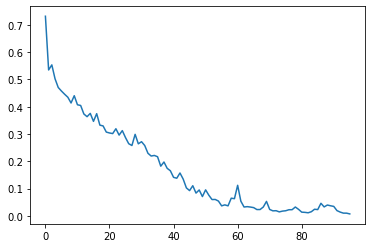

In [69]:
tf_loss = tf_model.history.history["loss"]
plt.plot(range(len(tf_loss)),tf_loss)

In [70]:
tf_timeseries_pred = []

first_eval_batch = standard_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(len(standard_test)):
    
    current_pred = tf_model.predict(current_batch)[0]
    
    tf_timeseries_pred.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [71]:
tf_inverted_preds = standard_scaler.inverse_transform(tf_timeseries_pred)
tf_inverted_preds

array([[379415.06],
       [386307.12],
       [363213.78],
       [384433.4 ],
       [371907.62],
       [355168.5 ],
       [331620.28],
       [338738.97],
       [337832.84],
       [329826.3 ],
       [336907.75],
       [342928.2 ],
       [337439.06],
       [334287.66],
       [310587.5 ],
       [326874.6 ],
       [318542.3 ],
       [319799.53],
       [325769.1 ],
       [320902.66],
       [315616.22],
       [309408.6 ],
       [305086.53],
       [302354.8 ],
       [309417.5 ],
       [311857.5 ],
       [313958.94],
       [317392.28],
       [325042.03],
       [314429.56],
       [304017.9 ],
       [300277.25],
       [320662.34]], dtype=float32)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




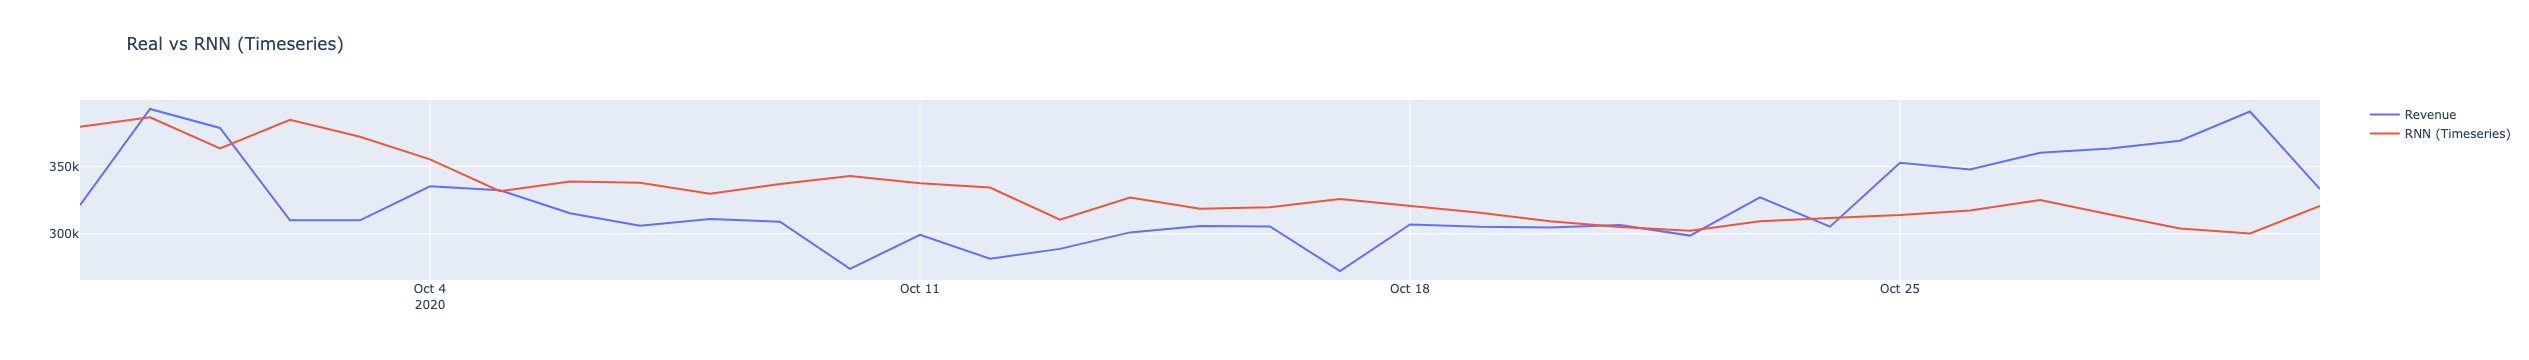

In [72]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=tf_inverted_preds.flatten(),name="RNN (Timeseries)"))
fig.update_layout(title="Real vs RNN (Timeseries)")
fig.show()

## Tensorflow Convolution Neural Net

In [73]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.3):
            print("\nReached acceptable loss!")
            self.model.stop_training = True

In [100]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=64,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1),
])

In [101]:
conv_model.compile(optimizer="adam",loss="mse")

In [102]:
conv_model.fit_generator(timeseries_gen,epochs=100,callbacks=[callback])

Epoch 1/100
78/78 [==============================] - 1s 7ms/step - loss: 0.6946
Epoch 2/100
78/78 [==============================] - 1s 7ms/step - loss: 0.6661
Epoch 3/100
78/78 [==============================] - 1s 8ms/step - loss: 0.6444
Epoch 4/100
78/78 [==============================] - 1s 7ms/step - loss: 0.6024
Epoch 5/100
78/78 [==============================] - 1s 9ms/step - loss: 0.6246
Epoch 6/100
78/78 [==============================] - 1s 8ms/step - loss: 0.5681
Epoch 7/100
78/78 [==============================] - 1s 10ms/step - loss: 0.5488
Epoch 8/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5282
Epoch 9/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5377
Epoch 10/100
78/78 [==============================] - 1s 8ms/step - loss: 0.5062
Epoch 11/100
78/78 [==============================] - 1s 9ms/step - loss: 0.4830
Epoch 12/100
78/78 [==============================] - 1s 10ms/step - loss: 0.4926
Epoch 13/100
78/78 [===============

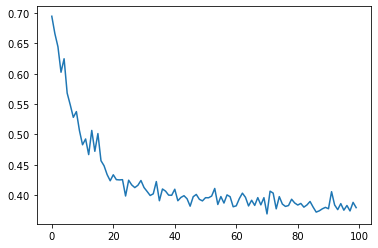

In [103]:
conv_loss = conv_model.history.history["loss"]
plt.plot(range(len(conv_loss)),conv_loss)

In [104]:
conv_eval_batch = standard_train[-n_inputs:]
conv_current_batch = first_eval_batch.reshape((1,n_inputs,n_features))
conv_timeseries_pred = []

for i in range(len(standard_test)):
    
    current_pred = conv_model.predict(current_batch)
    #Flatten 3d to 1
    append_pred = np.matrix.flatten(current_pred)[-1]
    conv_timeseries_pred.append(append_pred)
        
    current_batch = np.append(current_batch[:,1:,:],[[[append_pred]]],axis=1)

In [105]:
new_preds = [[[conv_timeseries_pred]]]

In [106]:
conv_inverted_preds = standard_scaler.inverse_transform(new_preds)

In [107]:
conv_inverted_preds

array([[[[319061.22, 324298.78, 317097.8 , 325442.9 , 332009.53,
          349954.62, 340330.66, 343688.12, 353662.88, 344522.84,
          338542.3 , 333902.06, 323863.6 , 313864.1 , 293998.66,
          286389.12, 295073.47, 307682.56, 322084.53, 327305.66,
          334712.97, 355830.44, 352288.4 , 354402.47, 363286.1 ,
          337204.03, 334679.34, 322538.97, 317126.34, 296362.8 ,
          287852.06, 294997.44, 307026.97]]]], dtype=float32)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




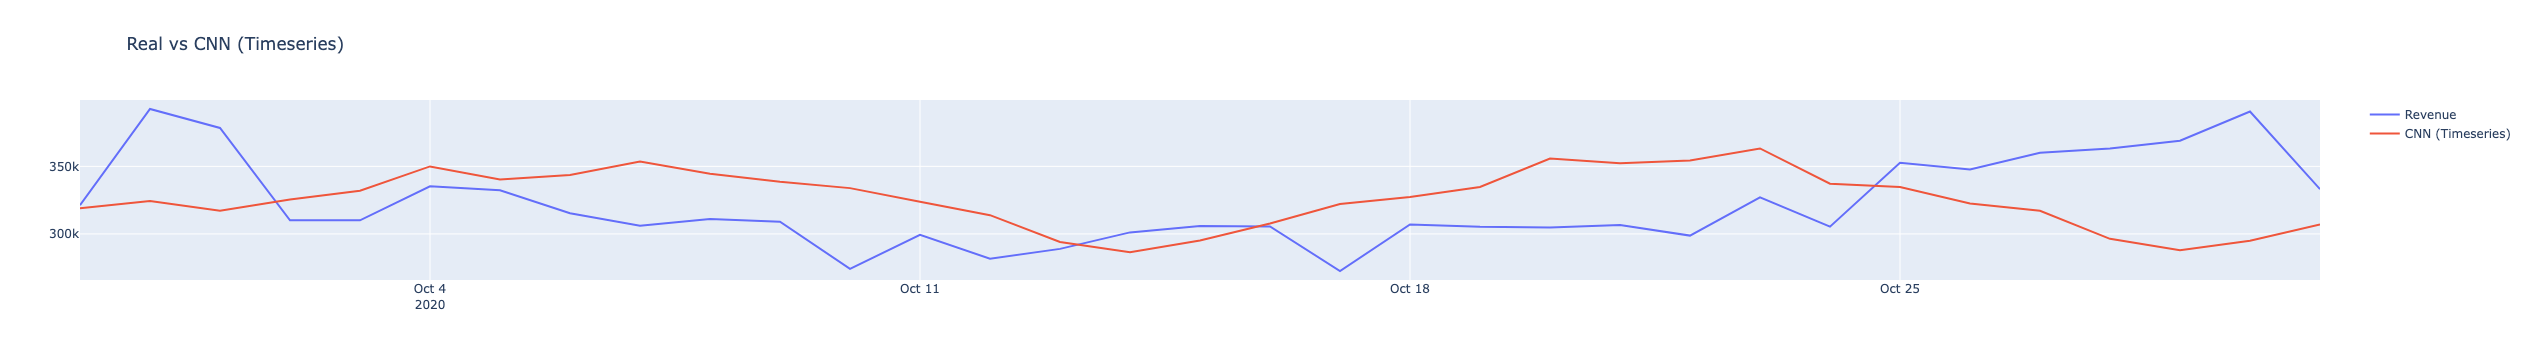

In [108]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=conv_inverted_preds.flatten(),name="CNN (Timeseries)"))
fig.update_layout(title="Real vs CNN (Timeseries)")
fig.show()

## Comparing Model Performance

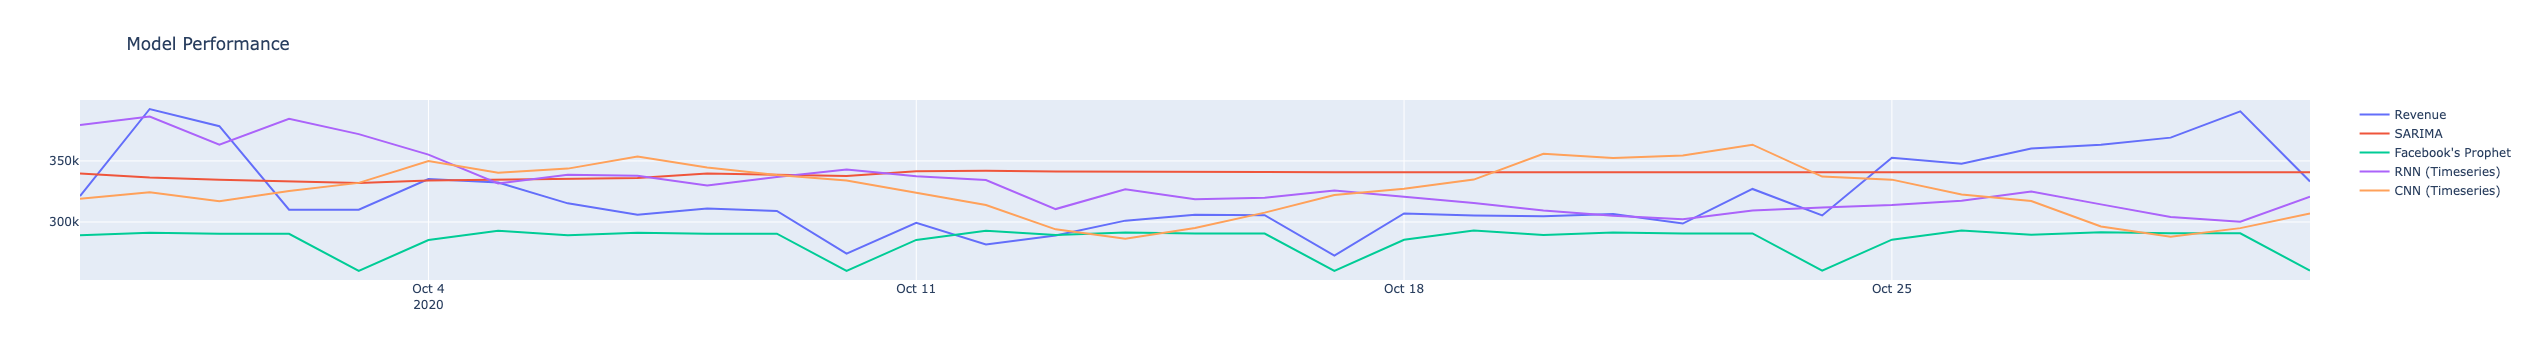

In [109]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=sarima_predictions.index,y=sarima_predictions,name="SARIMA"))
fig.add_trace(go.Line(x=prophet_forecast["ds"].iloc[90:],y=prophet_forecast["yhat"].iloc[90:],name="Facebook's Prophet"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=tf_inverted_preds.flatten(),name="RNN (Timeseries)"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=conv_inverted_preds.flatten(),name="CNN (Timeseries)"))
fig.update_layout(title="Model Performance")
fig.show()

### MSE and RMSE for each model

In [110]:
from sklearn.metrics import mean_squared_error, r2_score

In [111]:
real_values = df['Revenue'].iloc[90:]

mse_sarima = mean_squared_error(real_values,sarima_predictions)

In [112]:
mse_fb = mean_squared_error(real_values,prophet_forecast["yhat"].iloc[90:])

In [113]:
mse_rnn = mean_squared_error(real_values,tf_inverted_preds.flatten())

In [114]:
mse_cnn = mean_squared_error(real_values,conv_inverted_preds.flatten())

In [115]:
rmse_sarima = np.sqrt(mse_sarima)
rmse_fb = np.sqrt(mse_fb)
rmse_rnn = np.sqrt(mse_rnn)
rmse_cnn = np.sqrt(mse_cnn)

In [116]:
r2_sarima = r2_score(real_values,sarima_predictions)
r2_fb = r2_score(real_values,prophet_forecast["yhat"].iloc[90:])
r2_rnn = r2_score(real_values,tf_inverted_preds.flatten())
r2_cnn = r2_score(real_values,conv_inverted_preds.flatten())

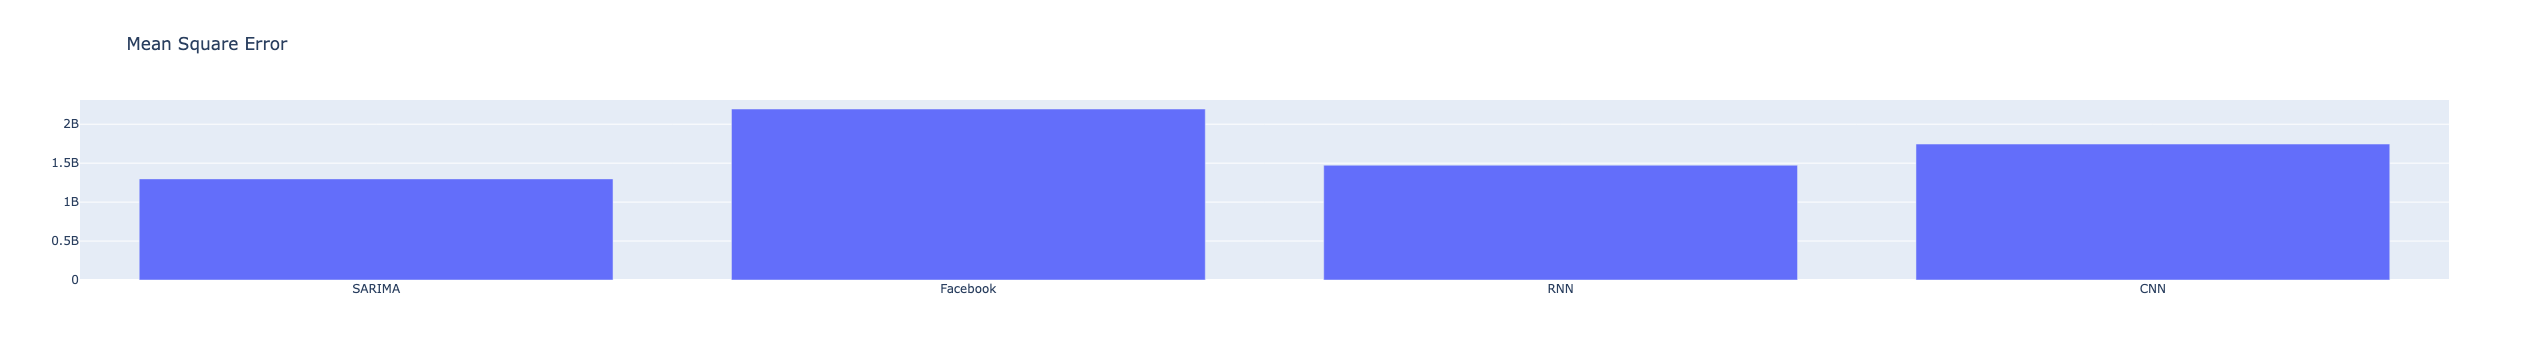

In [117]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Bar(x=["SARIMA","Facebook","RNN","CNN"],y=[mse_sarima,mse_fb,mse_rnn,mse_cnn]))
fig.update_layout(title="Mean Square Error")
fig.show()

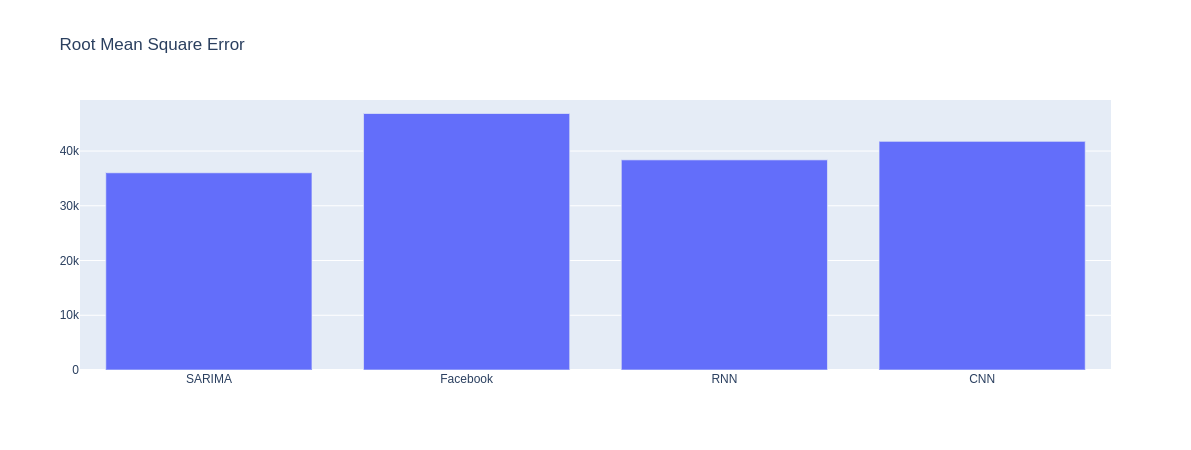

In [118]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Bar(x=["SARIMA","Facebook","RNN","CNN"],y=[rmse_sarima,rmse_fb,rmse_rnn,rmse_cnn]))
fig.update_layout(title="Root Mean Square Error")
fig.show()